# GRACE & GRACE FO downscaling project


<font color='Cyan'>This s a notebok for downscaling GRACE data using ERA5. Downscaling is done using XGBoost or Random Forest models.</font>


<font size="2">To run this notebook, first install the required packages as described in the README_notebook.md file. It is recomended to create a virtual environment and install the packages there. 
It is also recomended to create a similar folder structure as the one in the README_notebook.md file.</font>

<font size="2">Download ERA5 data. To do so follow first instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows. If you are using a different OS, follow instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Linux+or+Mac. You can see details on the ERA5 variables at https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download. Please have in mind that if you want to use a different variable, you need to modify the backend_notebook.ipynb file.</font>

# <font size="4"> Import dependencies </font>

In [1]:
import cdsapi
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
import xgboost as xgb
import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
from colorama import Fore
import seaborn as sns
from scipy.interpolate import griddata

# <font size="4"> ERA5 Data Download </font>

In [ ]:
#Download ERA5 data from the Copernicus Data Store API
import cdsapi

dataset = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_temperature",
        "total_precipitation",
        "total_evaporation",
        "potential_evaporation",
        "sub_surface_runoff",
        "surface_runoff",
        "evaporation_from_bare_soil",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "leaf_area_index_high_vegetation",
        "leaf_area_index_low_vegetation"
    ],
    "year": [
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "zip"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-12-22 17:21:28,657 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


KeyboardInterrupt: 

# <font size="4"> Import datasets</font>

In [2]:
#Import datasets
#Import datasets
CSR_path  = "../data/CSR_Mascon_Grace.nc"
ERA_path = "../data/ERA5_data.nc"

In [3]:
# read-print dataset
ds = xr.open_dataset(CSR_path)
ds_era5= xr.open_dataset(ERA_path)

# print(ds.head())
# print(ds_era5.head())


# <font size="4"> Data Slicing to Region of Interest </font>

In [4]:
# Data slicing to Area of Interest

print("Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]")
try:
    lat_min = float(input("Latitude Min : "))
    lat_max = float(input("Latitude Max : "))
    lon_min = float(input("Longitude Min : "))
    lon_max = float(input("Longitude Max : "))
except ValueError:
    print("Wrong input! Please insert a number!")
print(f"\nArea of Interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}]")

# Slice function
def slice_nc(ds, ds_name):
    print(f"\nSlicing {ds_name}")

    possible_lat_names = ['lat', 'latitude']
    possible_lon_names = ['lon', 'longitude']
    
    lat_name = None
    lon_name = None

    print("Checking for possible lat/lon names ")
    for name in ds.coords:
        # Checking with .lower() for possible lat/lon names
        if name.lower() in possible_lat_names:
            lat_name = name
        elif name.lower() in possible_lon_names:
            lon_name = name
    
    if not lat_name or not lon_name:
        raise ValueError(f" ERROR: There are no lat/lon columns in {ds_name}")

    # Converting Longitude (0-360 -> -180,180) ---
    if ds[lon_name].max() > 180:
        print(" Converting Longitude in -180,180")
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)})
    ds = ds.sortby(lon_name)

    # Check convertion
    lat_values = ds[lat_name].values  
    # Sorting
    if lat_values[0] > lat_values[-1]: 
        lat_slice = slice(lat_max, lat_min)
    else:
        lat_slice = slice(lat_min, lat_max)

    # Final slice to Area of Interest
    ds_sliced = ds.sel({
        lat_name: lat_slice, 
        lon_name: slice(lon_min, lon_max)
    })
    return ds_sliced

ds_grace_sliced = slice_nc(ds, "GRACE")
ds_era5_sliced = slice_nc(ds_era5,"ERA5")
print(f"\nCreated a data slice to the area of interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}] ")

Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]

Area of Interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0]

Slicing GRACE
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing ERA5
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Created a data slice to the area of interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0] 


# <font size="4"> Create year, month columns for data alignment </font>

In [5]:
# Fixing the time variable in GRACE data: exporting year and month from timestamp
ds = ds_grace_sliced
ds["time"] = pd.to_datetime(
    ds.time.values, origin="2002-01-01", unit="D"
)

# Drop time_bounds column, if it exists
ds = ds.drop_vars("time_bounds", errors="ignore")
# print(ds)

# Convert xarray dataset to pandas dataframe
ds = ds_grace_sliced
grace_df = ds.to_dataframe().reset_index()
# print(grace_df.head())

# Add year and month columns to the dataframe
grace_df["year"] = grace_df["time"].dt.year
grace_df["month"] = grace_df["time"].dt.month
# print(grace_df) 

In [6]:
# Convert ERA5 data to DataFrames
era5_df= ds_era5_sliced.to_dataframe().reset_index()
# Fix the time variable in ERA5 data: exporting year and month from timestamp

era5_df["year"] = era5_df["valid_time"].dt.year
era5_df["month"] = era5_df["valid_time"].dt.month

# Rename longitude and latitude columns for data alignment

era5_df = era5_df.rename(columns={"longitude": "lon", "latitude": "lat"})
era5_df=era5_df.drop(columns=['valid_time', 'number', 'expver'])
print(era5_df.head())

   lat   lon  t2m  tp   e  pev  ssro  sro  evabs  swvl1  swvl2  swvl3  swvl4  \
0  4.9 -79.9  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
1  4.9 -79.8  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
2  4.9 -79.7  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
3  4.9 -79.6  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
4  4.9 -79.5  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   

   lai_hv  lai_lv  year  month  
0     NaN     NaN  2002      1  
1     NaN     NaN  2002      1  
2     NaN     NaN  2002      1  
3     NaN     NaN  2002      1  
4     NaN     NaN  2002      1  


# <font size="4"> Merge ERA5 and GRACE datasets => Create training dataset </font>

In [7]:
# Compute GRACE resolution

g_lats = np.sort(grace_df["lat"].unique()) 
g_lons = np.sort(grace_df["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE resolution ~", step, "degrees")

GRACE resolution ~ 0.25 degrees


In [8]:
# Regrid the merged ERA5 dataframe to match the grace_df grid (use step variable from the cell above)
grace_df["lat_r"] = (grace_df["lat"] / step).round() * step
grace_df["lon_r"] = (grace_df["lon"] / step).round() * step

era5_df2=era5_df.copy()
era5_df2["lat_r"] = (era5_df2["lat"] / step).round() * step
era5_df2["lon_r"] = (era5_df2["lon"] / step).round() * step
# print(grace_df.head())
era5_df2 = era5_df2.groupby(["year", "month", "lat_r", "lon_r"]).mean().reset_index()
print(era5_df2.head())
print(grace_df.head())

   year  month  lat_r  lon_r    lat    lon  t2m  tp   e  pev  ssro  sro  \
0  2002      1  -17.0 -80.00 -16.95 -79.90  NaN NaN NaN  NaN   NaN  NaN   
1  2002      1  -17.0 -79.75 -16.95 -79.75  NaN NaN NaN  NaN   NaN  NaN   
2  2002      1  -17.0 -79.50 -16.95 -79.50  NaN NaN NaN  NaN   NaN  NaN   
3  2002      1  -17.0 -79.25 -16.95 -79.25  NaN NaN NaN  NaN   NaN  NaN   
4  2002      1  -17.0 -79.00 -16.95 -79.00  NaN NaN NaN  NaN   NaN  NaN   

   evabs  swvl1  swvl2  swvl3  swvl4  lai_hv  lai_lv  
0    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
1    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
2    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
3    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
4    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
        time  timebound     lat     lon  time_bounds  lwe_thickness  year  \
0 2002-04-18          0 -16.875 -79.875         94.0      -0.473648  2002   
1 2002-04-18          0 -16.875 -79.625         94.0      -0.4736

In [9]:
# Final merge of GRACE and ERA5 datasets
# Merged dataframe is going to be used for training the model
merged = pd.merge(
    grace_df,
    era5_df2,
    on=["year", "month", "lat_r", "lon_r"],
    how="inner",
    suffixes=("_grace", "_era")
)
#print(merged.head())

# Remove rows with year 2025 and above. Training is going to be done up to 2024. 
# 2025 and on is going to be used for testing

merged= merged[merged['year'] <= 2024]
print(f"Most recent year in training dataset: {merged['year'].max()}")

data_out = ['time','lat_r','lat_era','lon_r','lon_era']
merged = merged.drop(columns = data_out, errors='ignore')
merged.rename(columns={"lon_grace": "lon", "lat_grace": "lat"}, inplace=True)
print(merged.tail())

Most recent year in training dataset: 2024
         timebound    lat     lon  time_bounds  lwe_thickness  year  month  \
5068795          1  4.875 -51.125       8401.0       0.516883  2024     12   
5068796          1  4.875 -50.875       8401.0      -0.308139  2024     12   
5068797          1  4.875 -50.625       8401.0      -0.308139  2024     12   
5068798          1  4.875 -50.375       8401.0      -0.308139  2024     12   
5068799          1  4.875 -50.125       8401.0       0.947064  2024     12   

         t2m  tp   e  pev  ssro  sro  evabs  swvl1  swvl2  swvl3  swvl4  \
5068795  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5068796  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5068797  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5068798  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5068799  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   

         lai_hv  lai_lv  
5068795    

# <font size="4"> Choose model, Train the ERA5 data on GRACE data </font>

In [10]:
# Choose the model
print("Choose the model you want to use: (XGBoost/RF)")
try:
    model_used = (input("Choose ML model (XGBoost/RF): "))
except ValueError:
    print("Error! Please enter 'XGBoost' or 'RF'.")
print(f"The prediction will be made with the model {model_used}")

# Drop NaN values
df_clean = merged.dropna()
print(f"Total samples available: {len(df_clean):,}")

# PERFORMANCE FIX: Sample data for RFE to speed up feature selection
max_rfe_samples = 50000  # Adjust as needed (50k-100k is usually sufficient)
if len(df_clean) > max_rfe_samples:
    print(f"Sampling {max_rfe_samples:,} rows for RFE (faster feature selection)...")
    df_rfe = df_clean.sample(n=max_rfe_samples, random_state=42)
else:
    print("Using all data for RFE...")
    df_rfe = df_clean

y = df_clean["lwe_thickness"]
y_rfe = df_rfe["lwe_thickness"]

if model_used == "XGBoost":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','evabs','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    x_rfe = df_rfe.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=50, random_state=42, n_jobs=-1)

elif model_used == "RF":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','evabs','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    x_rfe = df_rfe.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
else:
    print("Invalid model input!")
    print("Please enter 'XGBoost' or 'RF'.")
# Choose the number of features you want to select for the RFE
print("Choose the number of features you want to select")
try: 
    n_features_to_select = int(input("Insert the number of features you want to select : ")) 
    print(f"The RFE will be performed with: {n_features_to_select} features")
except ValueError:
    print("Invalid input!")
    sys.exit()

# RFE Classification (on sampled data for speed)
print(f"\nRunning RFE on {len(df_rfe):,} samples...")
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) 
rfe.fit(x_rfe, y_rfe)

# Print selected features from RFE
selected_features = x.columns[rfe.support_].tolist()

print("\n RFE Results!")
print(f" Τα {n_features_to_select} Best Features are:")
print(selected_features)

Choose the model you want to use: (XGBoost/RF)
The prediction will be made with the model XGBoost
Total samples available: 4,759,200
Sampling 50,000 rows for RFE (faster feature selection)...
Features included in training: ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'pev', 't2m', 'evabs', 'lai_hv', 'lai_lv']
Choose the number of features you want to select
The RFE will be performed with: 4 features

Running RFE on 50,000 samples...

 RFE Results!
 Τα 4 Best Features are:
['tp', 'ssro', 'swvl4', 't2m']


# <font size="4"> RFE ranking graph </font>

Map saved to ../results/RFE_ranking_4_features.jpg


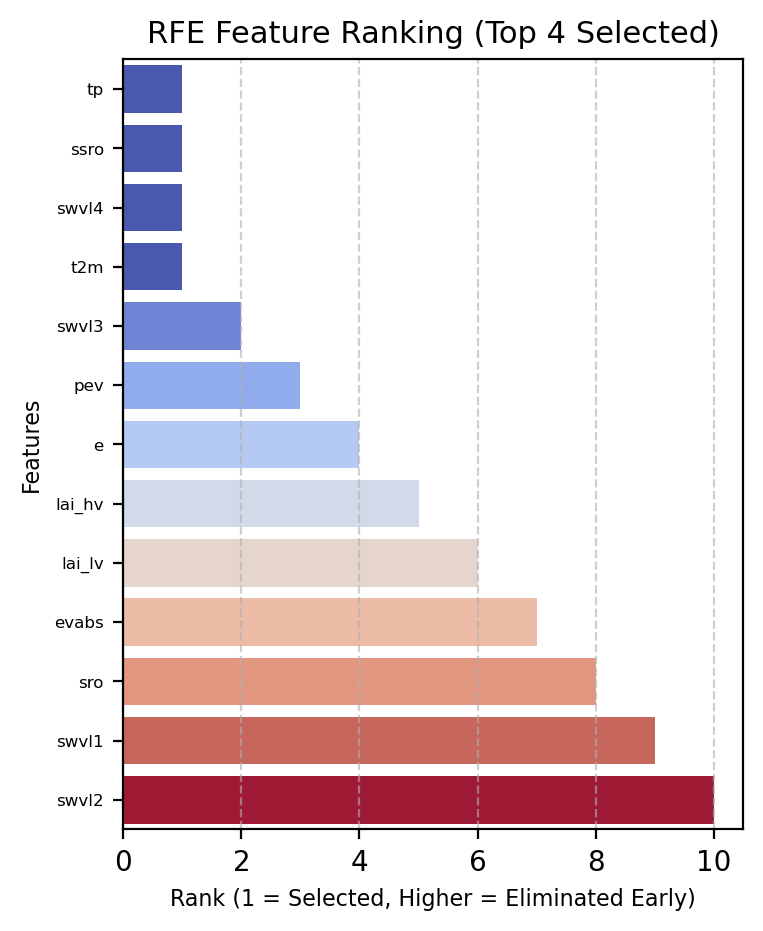

In [11]:
# Dynamic title output save without overwrtie
output_jpg_RFE = f"../results/RFE_ranking_{rfe.n_features_}_features.jpg"

# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_RFE):
    output_jpg_RFE = f"../results/RFE_ranking_{rfe.n_features_}_features_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_RFE}")

# Creating pandas df
df_ranking = pd.DataFrame()
# Creating column "Feature" in order to save the rfe feature names participating 
df_ranking["Feature"] = x.columns
# Creating column "Rank" in order to save the rfe feature ranking
df_ranking["Rank"] = rfe.ranking_ 
# Sorting df_ranking based on column "Rank", in ascending order (True)
df_ranking = df_ranking.sort_values(by=['Rank'], ascending=True)
#print(df_ranking)

# Creating figure
plt.figure(figsize=(4, 5), dpi=200) 
# hue = controls the colour by grouping the input data
# creating the barplot graph
sns.barplot(data=df_ranking, x="Rank", y="Feature", hue="Rank",palette="coolwarm", legend=False)

#Formatting
plt.title(f"RFE Feature Ranking (Top {rfe.n_features_} Selected)", fontsize=11)
plt.xlabel("Rank (1 = Selected, Higher = Eliminated Early)", fontsize=8)
plt.ylabel("Features", fontsize=8)
plt.grid(axis="x", linestyle="--", alpha=0.6)
#Changing feature fontsize
plt.yticks(fontsize=6)
# Show the plot

plt.savefig(output_jpg_RFE)
plt.show()

In [34]:
# Model training and export
# Create array with selected features
x_final = x[selected_features]
print(f"Training will use: \n {x_final.head(1)}")
target = "lwe_thickness"
extra_features = ["year", "month", "lon", "lat"]
base_features = list(x_final.columns)
# Final feature list
features = base_features + extra_features
features = [col for col in features if col != target]
# Define X and y
X = merged[features]
y = merged[target]

# Split into training and validation datasets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

if model_used == "XGBoost":
    print("  XGBoost Tuning...")
    param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [6,10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.5, 1.0]
    }

    final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=12,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,                      
        verbose=2,
        random_state=42
    )

    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print(" Best XGBoost Parameters:", best_params)

    best_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

elif model_used == "RF":
    param_grid = {
        'n_estimators': [200, 300],        
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    }

    final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-FOLD → faster
    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=8,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Fit tuner
    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print("Best Parameters:", best_params)

    # Train final model with best params
    best_model = RandomForestRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)

    # Predict
    y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error (σε cm)
r2 = r2_score(y_test, y_pred) # R-squared (max=1.0)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print(f" R² Score : {r2:.4f}  (Excellent = 1.0)")
print(f" RMSE :      {rmse:.4f} cm")
print(f" ΜΑΕ : {mae:.4f} ")
print(f" BIAS :   {bias:.4f} cm")

# Ask user for model name
model_name = input("Enter model filename (without extension): ").strip()
if not model_name:
    model_name = "model"  # default name

models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)  # Create models folder if it doesn't exist

model_path = str(models_dir / f"{model_name}.pkl")
print(f"Saving model to: {model_path}")

joblib.dump(best_model, model_path)
print(f"✓ Model saved successfully!")


Training will use: 
           tp  ssro     swvl4         t2m
31  0.000599   0.0  0.074554  291.538666
  XGBoost Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best XGBoost Parameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
 R² Score : 0.9987  (Excellent = 1.0)
 RMSE :      0.7499 cm
 ΜΑΕ : 0.2617 
 BIAS :   0.0003 cm
Saving model to: h:\Karachles_thesis\final\grace_project\models\xgboost_4_new.pkl
✓ Model saved successfully!


# <font size="4"> Compute training curves RF </font>

Training with:
           tp  ssro     swvl4         t2m
31  0.000599   0.0  0.074554  291.538666

Tuning begins (subset)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Computing learning curves...
Trees:   10 | Train MAE: 2.4024 | Val MAE: 4.5701
Trees:   25 | Train MAE: 2.1707 | Val MAE: 4.3154
Trees:   40 | Train MAE: 2.1195 | Val MAE: 4.2496
Trees:   55 | Train MAE: 2.0760 | Val MAE: 4.1950
Trees:   71 | Train MAE: 2.0615 | Val MAE: 4.1795
Trees:   86 | Train MAE: 2.0500 | Val MAE: 4.1652
Trees:  101 | Train MAE: 2.0470 | Val MAE: 4.1563
Trees:  116 | Train MAE: 2.0444 | Val MAE: 4.1521
Trees:  132 | Train MAE: 2.0398 | Val MAE: 4.1448
Trees:  147 | Train MAE: 2.0376 | Val MAE: 4.1467
Trees:  162 | Train MAE: 2.0322 | Val MAE: 4.1392
Trees:  177 | Train MAE: 2.0295 | Val MAE: 4.1379
Trees:  193 | Train MAE: 2.0264 | Val MAE: 4.1367
Trees:

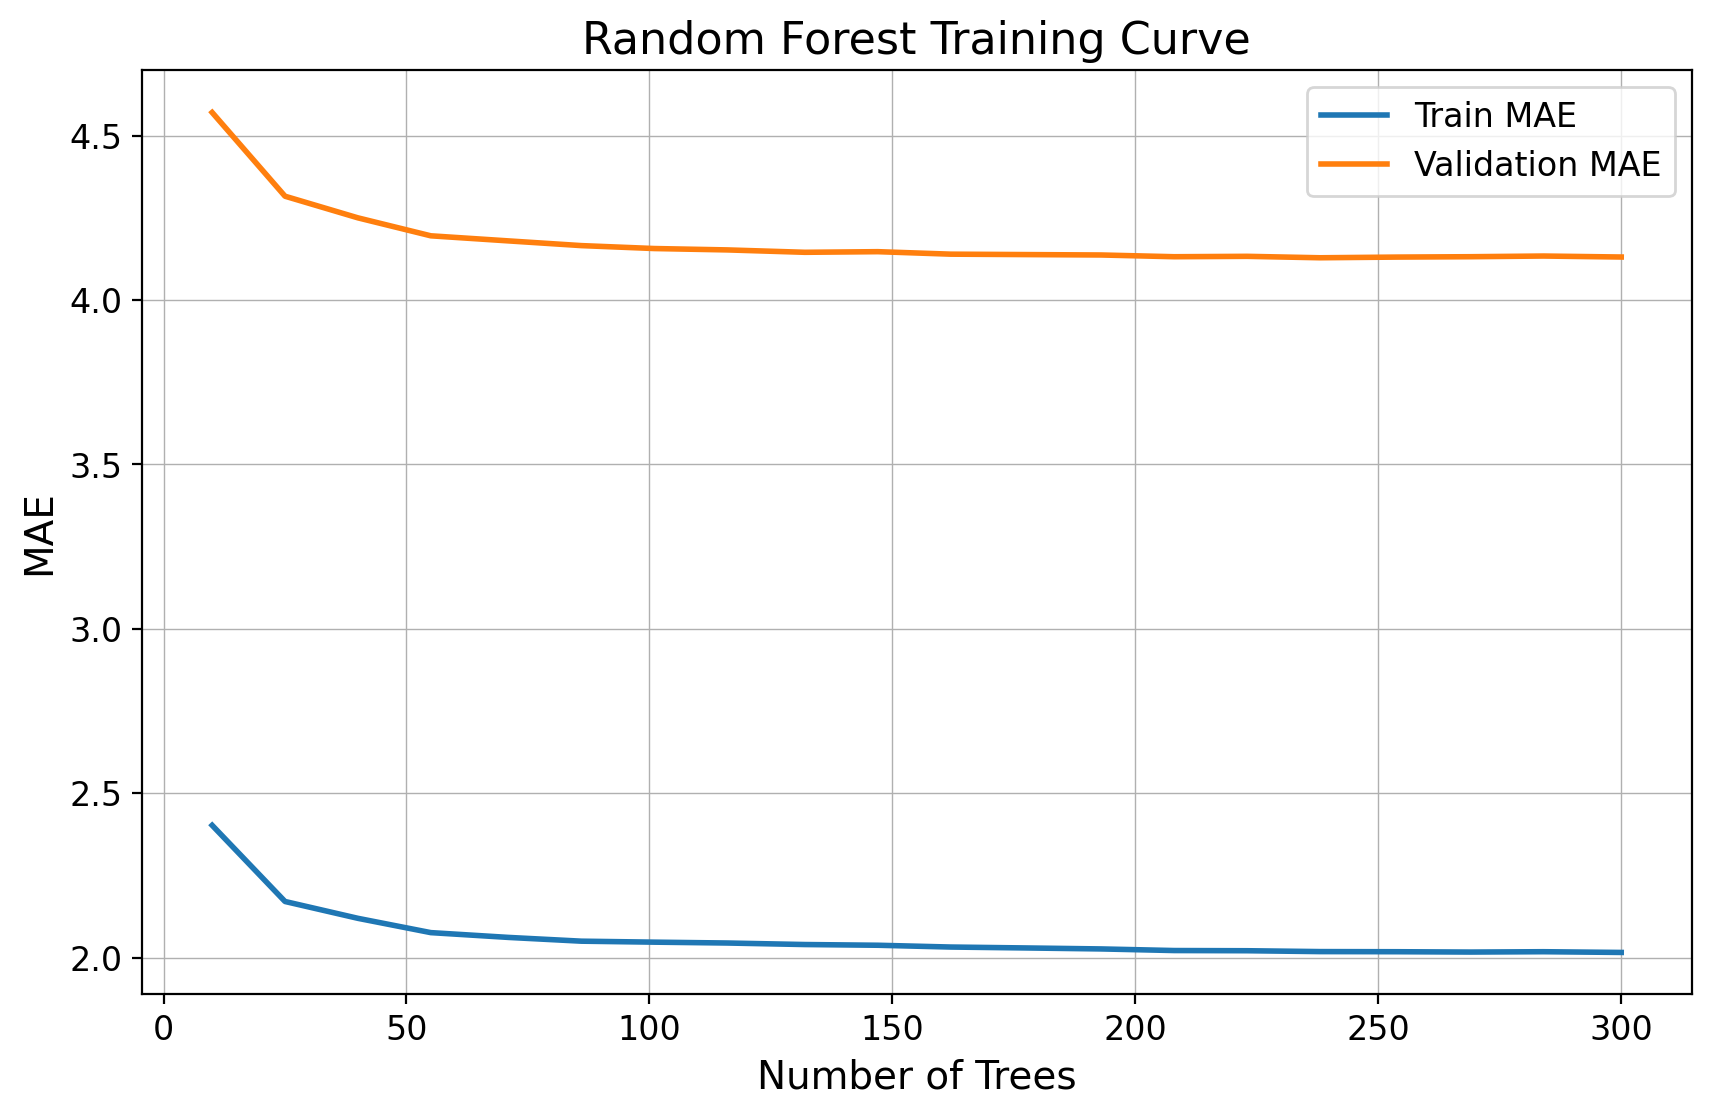


 Training curve saved to: ../results/random_forest_training_curve.png

Training final model on the full training set

Results on test set:
 R² Score : 0.9660
 RMSE :       3.8845 cm
 MAE (Mean Absolute Error) :    2.2001
 BIAS :    -0.0011 cm


In [18]:
# Compute the training curves graph

x_final = x[selected_features]
print("Training with:\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon", "lat"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Max Data Sample
max_tuning_samples = 100000 #adjust as needed eg 50000

if len(X_train) > max_tuning_samples:
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) 

tuner = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid, 
    n_iter=10,   
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nTuning begins (subset)...")
tuner.fit(X_train_sub, y_train_sub) 
best_params = tuner.best_params_ 
print(f"\nBest Parameters: {best_params}")

max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)

rf_curves = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=1,
    warm_start=True,
    n_jobs=-1
)

train_mae_list = []
val_mae_list = []
current_trees = 0

print("\nComputing learning curves...")
for n_trees in curve_steps:
    rf_curves.n_estimators = int(n_trees)
    rf_curves.fit(X_train_sub, y_train_sub)

    y_train_pred = rf_curves.predict(X_train_sub)
    y_val_pred = rf_curves.predict(X_val)

    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Random Forest Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)
curve_path = "../results/random_forest_training_curve.png"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f"\n Training curve saved to: {curve_path}")

best_rf = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=best_params['n_estimators'],
    n_jobs=-1
)

print("\nTraining final model on the full training set")
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("\nResults on test set:")
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error) :    {mae:.4f}")
print(f" BIAS :    {bias:.4f} cm")



 # <font size="4"> Compute training curves XGBoost</font>

 Starting XGBoost analysis 
Model training will be performed with features::
           tp  ssro     swvl4         t2m
31  0.000599   0.0  0.074554  291.538666
 Χρήση δείγματος 100000 για το Tuning...

 Starting Tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Calculating learning curves for XGBoost (for 500 trees)
Trees:   10 | Train MAE: 10.0641 | Val MAE: 10.1861
Trees:   35 | Train MAE: 5.1711 | Val MAE: 5.5777
Trees:   61 | Train MAE: 3.6910 | Val MAE: 4.3041
Trees:   87 | Train MAE: 3.0295 | Val MAE: 3.7662
Trees:  113 | Train MAE: 2.6625 | Val MAE: 3.4882
Trees:  138 | Train MAE: 2.4430 | Val MAE: 3.3378
Trees:  164 | Train MAE: 2.2840 | Val MAE: 3.2502
Trees:  190 | Train MAE: 2.1490 | Val MAE: 3.1779
Trees:  216 | Train MAE: 2.0355 | Val MAE: 3.1265
Trees:  242 | Train MAE: 1.9421 | Val MAE: 3.0883
Trees:  267 | Train MAE: 1.8663 |

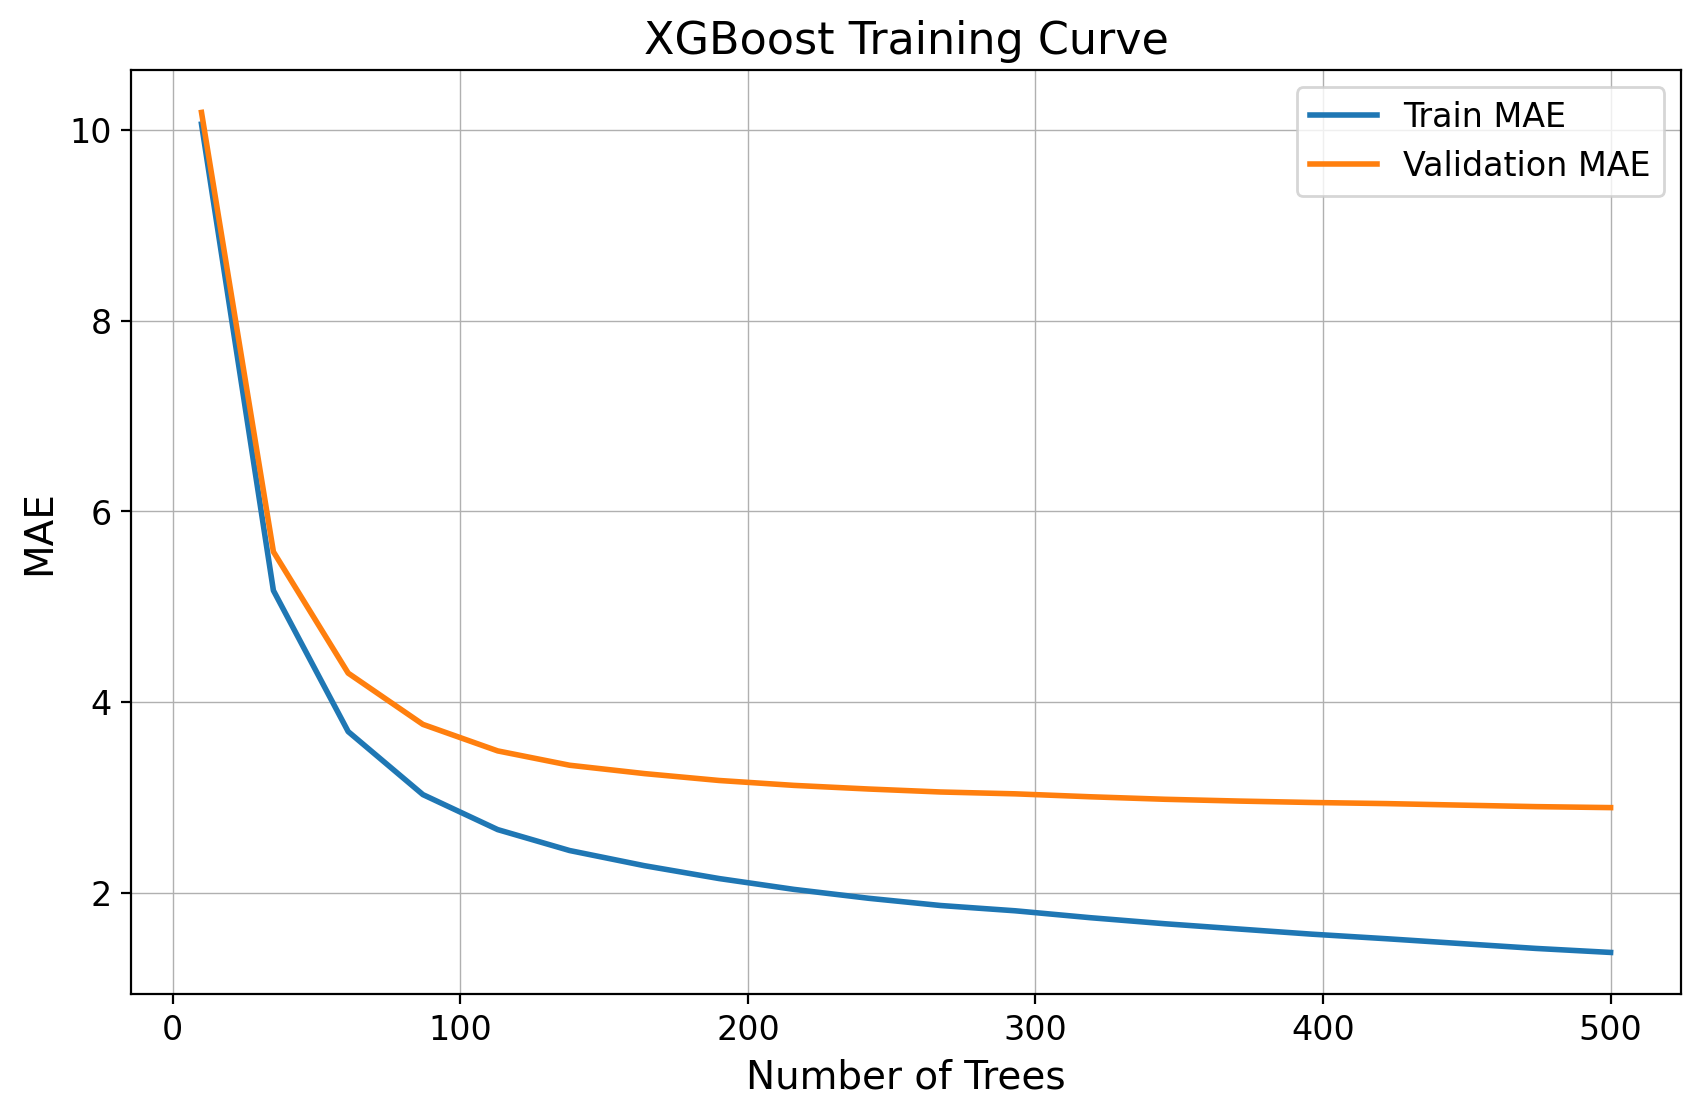

 Training curve saved to : ../results/XGBoost_training_curve.png

 Training final model with 300 trees
------------------------------
 R² Score : 0.9685
 RMSE :       3.7411 cm
 MAE (Mean Absolute Error):    2.3487 cm
 BIAS :    0.0015 cm
------------------------------


In [36]:
#XGB_learning curve

print(" Starting XGBoost analysis ")
x_final = x[selected_features]
print("Model training will be performed with features::\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon", "lat"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_tuning_samples = 100000 

if len(X_train) > max_tuning_samples:
    print(f" Χρήση δείγματος {max_tuning_samples} για το Tuning...")
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

# Tuning 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

param_grid = {
    'n_estimators': [100, 200, 500], #500
    'max_depth': [10, 15, 6], 
    'colsample_bytree': [0.7, 0.8, 1], #0.7,0.8,1
    'min_child_weight': [1, 3, 5], 
    'learning_rate': [0.01, 0.05, 0.1] #0.01,0.05,0.1
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) #5

tuner = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,                      
    scoring='neg_mean_absolute_error', 
    cv=kf,                          
    verbose=1,
    n_jobs=-1,                      
    random_state=42
)

print("\n Starting Tuning")
tuner.fit(X_train_sub, y_train_sub)
best_params = tuner.best_params_
print(f"\n Best Parameters {best_params}")

# Using optimal number of trees found by Tuning
max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)
# Lists for storing results
train_mae_list = []
val_mae_list = []

print(f"\nCalculating learning curves for XGBoost (for {max_trees} trees)")

for n_trees in curve_steps:
    
    # Create a temporary model for this step
    # We use the best_params except n_estimators (which we set manually here)
    # Filter parameters to remove 'n_estimators'
    params_without_n = {k: v for k, v in best_params.items() if k != 'n_estimators'}
    
    xgb_curves = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,             
        n_estimators=int(n_trees), 
        **params_without_n     
    )
    
    # Train on the subset (sub)
    xgb_curves.fit(X_train_sub, y_train_sub)

    # Predictions
    y_train_pred = xgb_curves.predict(X_train_sub)
    y_val_pred = xgb_curves.predict(X_val)

    # Calculating errors
    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

# plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('XGBoost Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)


# Saving plot
curve_path = "../results/XGBoost_training_curve.png"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f" Training curve saved to : {curve_path}")

final_n_estimators = 300  

print(f"\n Training final model with {final_n_estimators} trees")

best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    **{k: v for k, v in best_params.items() if k != 'n_estimators'}, 
    n_estimators=final_n_estimators
)

best_xgb.fit(X_train, y_train)

# Evaluation
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("-" * 30)
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error):    {mae:.4f} cm")
print(f" BIAS :    {bias:.4f} cm")
print("-" * 30)


# <font size="4"> stats </font>

In [10]:
grace_df2= grace_df.copy()
data_off = ['time','lat_r','lon_r']
grace_df2 = grace_df2.drop(columns= data_off, errors='ignore')
print(grace_df2.head())
target_lats = np.sort(era5_df["lat"].unique())
target_lons = np.sort(era5_df["lon"].unique())
#indexing ='' Cartesian (‘xy’, default) or matrix (‘ij’) 
grid_lat, grid_lon = np.meshgrid(target_lats, target_lons, indexing='ij')

grace_regridded_list = []

for (year, month), group in grace_df2.groupby(['year', 'month']):
    # Source Points (Old GRACE Grid)
    points = group[['lat', 'lon']].values
    values = group['lwe_thickness'].values
    # Interpolate onto the ERA5 Grid
    # method='nearest' ensures we just copy the closest value (Big Tile logic)
    grid_z = griddata(points, values, (grid_lat, grid_lon), method='nearest')
    # Store result
    grace_regridded_list.append(pd.DataFrame({
        'year': year,
        'month': month,
        'lat': grid_lat.flatten(),
        'lon': grid_lon.flatten(),
        'lwe_thickness': grid_z.flatten()
    }))

grace_on_era5_grid = pd.concat(grace_regridded_list)
#print(grace_on_era5_grid.head())  
grace_df2= grace_on_era5_grid.copy()
print(grace_df2.head(10))


   timebound     lat     lon  time_bounds  lwe_thickness  year  month
0          0 -16.875 -79.875         94.0      -0.473648  2002      4
1          0 -16.875 -79.625         94.0      -0.473648  2002      4
2          0 -16.875 -79.375         94.0      -0.141746  2002      4
3          0 -16.875 -79.125         94.0      -0.141746  2002      4
4          0 -16.875 -78.875         94.0      -0.141746  2002      4
   year  month   lat   lon  lwe_thickness
0  2002      4 -17.0 -79.9      -0.473648
1  2002      4 -17.0 -79.8      -0.473648
2  2002      4 -17.0 -79.7      -0.473648
3  2002      4 -17.0 -79.6      -0.473648
4  2002      4 -17.0 -79.5      -0.473648
5  2002      4 -17.0 -79.4      -0.141746
6  2002      4 -17.0 -79.3      -0.141746
7  2002      4 -17.0 -79.2      -0.141746
8  2002      4 -17.0 -79.1      -0.141746
9  2002      4 -17.0 -79.0      -0.141746


In [11]:
#Checking grace_df2 resolution
g_lats = np.sort(grace_df2["lat"].unique()) 
g_lons = np.sort(grace_df2["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE interpolated resolution ~", step, "degrees")

GRACE interpolated resolution ~ 0.09999999999999964 degrees


In [18]:
#Import and select .pkl model
models_dir = "../models/"
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(" Error: No .pkl files found in the models directory!")
        sys.exit()

    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED + "  Invalid input. Please enter a number.")
        sys.exit()
except FileNotFoundError:
    print( Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

# Prediction 
input_data = era5_df
try:
    required_features = model.feature_names_in_
except AttributeError:
    print("Using default features")
    required_features = features

missing_feats = [c for c in required_features if c not in input_data.columns]
if missing_feats:
    raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")
# X_pred = rfe selection features
X_pred = input_data[required_features]
# Take table input_data create a new column (lwe_pred) and fill it with prediction 
input_data["lwe_pred"] = model.predict(X_pred)

#As we can check from the prints grace_df_2 starts from 04/2002 and input_data from 01/2002
# So we are gonna drop from input_data these 3 months (i suppose)
to_drop = (input_data['year'] == 2002) & (input_data['month'] < 4)

#Keep everything that is NOT (~) in that condition
predicted_data = input_data[~to_drop]

# For the wanted difference i will first merge the 2 dataframes and then i will create a new column, where i am gonna save the 
# lwe_pred - lwe_thickness result 

merged_4_diff = pd.merge(
    grace_df2,
    predicted_data,
    on=["year", "month", "lat", "lon"],
    how="inner",
    suffixes=("_grace", "_grace_pred")
)

data_out=['t2m', 'tp', 'e', 'pev', 'ssro', 'sro', 'evabs','swvl1', 'swvl2', 'swvl3', 'swvl4', 'lai_hv', 'lai_lv']
merged_4_diff = merged_4_diff.drop(columns=data_out, errors='ignore')
merged_4_diff["lwe_difference"] = abs(merged_4_diff["lwe_pred"] - merged_4_diff["lwe_thickness"])

#print(merged_4_diff.head())

# Stats computed for lwe_difference
lwe_diff_min = merged_4_diff["lwe_difference"].min()
lwe_diff_max = merged_4_diff["lwe_difference"].max()
lwe_diff_mean = merged_4_diff["lwe_difference"].mean()
lwe_diff_std = merged_4_diff["lwe_difference"].std()
mse_diff = mean_squared_error(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
rmse = np.sqrt(mse_diff)
r2 = r2_score(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
mae = mean_absolute_error(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
bias = np.mean(merged_4_diff["lwe_thickness"] - merged_4_diff["lwe_pred"])

# Stats computed for lwe_pred
lwe_pred_min = merged_4_diff["lwe_pred"].min()
lwe_pred_max = merged_4_diff["lwe_pred"].max()
lwe_pred_mean = merged_4_diff["lwe_pred"].mean()
lwe_pred_std = merged_4_diff["lwe_pred"].std()

# Stats computed for lwe_thickness
lwe_thickness_min = grace_df["lwe_thickness"].min()
lwe_thickness_max = grace_df["lwe_thickness"].max()
lwe_thickness_mean = grace_df["lwe_thickness"].mean()
lwe_thickness_std = grace_df["lwe_thickness"].std()

print(f"Model used {selected_model_name}")
print("Statistic analysis for lwe difference")
print(f"Minimum Difference : {lwe_diff_min:.4f} cm")
print(f"Maximum Difference : {lwe_diff_max:.4f} cm")
print(f"Mean Difference : {lwe_diff_mean:.4f} cm")
print(f"std Difference : {lwe_diff_std:.4f} cm")
#print(f"R² Score (Accuracy): {r2:.4f}")
#print(f"RMSE (Root Mean Sq Error): {rmse:.4f} cm")
#print(f"MAE (Mean Absolute Error): {mae:.4f} cm")
#print(f"Bias (Mean Error): {bias:.4f} cm")
#print(f"MSE (Mean Squared Error): {mse_diff:.4f} cm²")
print("-------------------------------------")
print("Statistic analysis for lwe prediction")
print(f"Minimum  : {lwe_pred_min:.4f} cm")
print(f"Maximum  : {lwe_pred_max:.4f} cm")
print(f"Mean  : {lwe_pred_mean:.4f} cm")
print(f"std  : {lwe_pred_std:.4f} cm")
print("-------------------------------------")
print("Statistic analysis for lwe thickness")
print(f"Minimum  : {lwe_thickness_min:.4f} cm")
print(f"Maximum  : {lwe_thickness_max:.4f} cm")
print(f"Mean  : {lwe_thickness_mean:.4f} cm")
print(f"std  : {lwe_thickness_std:.4f} cm")




Scanning directory: ../models/ 
 Available Models:
  [1] rf_4_new2.pkl
  [2] rf_amazon_5.pkl
  [3] xgboost_4_light.pkl
  [4] xgboost_4_new.pkl
  [5] xgboost_5_light.pkl
  [6] xgboost_5_parameters.pkl
  [7] xgboost_8_test.pkl
  Selected: xgboost_8_test.pkl
 Loading model...
Model used xgboost_8_test.pkl
Statistic analysis for lwe difference
Minimum Difference : 0.0000 cm
Maximum Difference : 142.5191 cm
Mean Difference : 2.6039 cm
std Difference : 3.7589 cm
-------------------------------------
Statistic analysis for lwe prediction
Minimum  : -133.3853 cm
Maximum  : 152.9392 cm
Mean  : -0.0551 cm
std  : 20.2158 cm
-------------------------------------
Statistic analysis for lwe thickness
Minimum  : -133.4621 cm
Maximum  : 175.9078 cm
Mean  : 0.2724 cm
std  : 21.0686 cm


# <font size="4"> ploting stats </font>

C:\Users\akara\AppData\Local\Temp\ipykernel_14284\2365705751.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


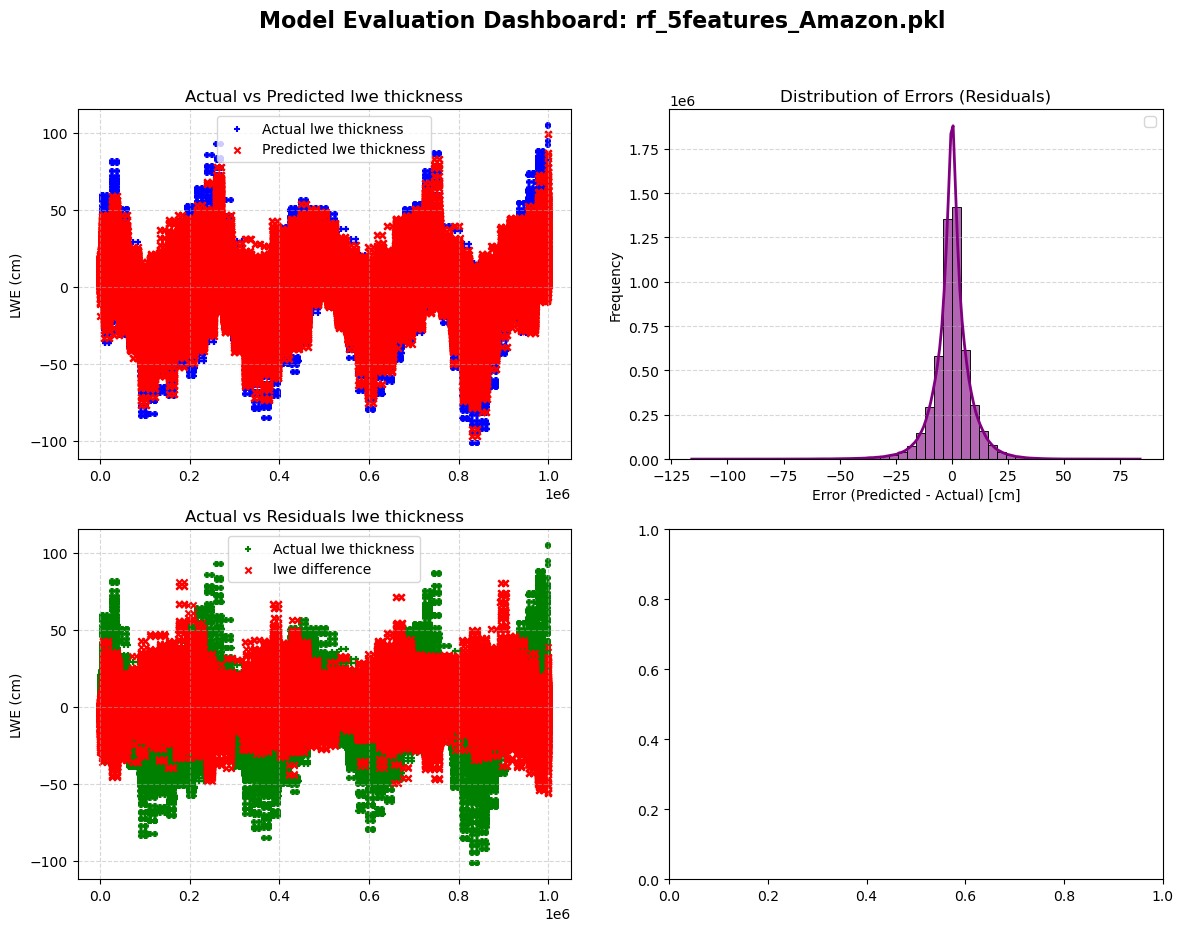

In [ ]:
#scatter plot 2 lines for before and after prediction
# histogramm of lwe_difference
#residual plot (diff vs actual)

# We are gonna start by preparing our data for the scatterplot 
#predicted
merged_4_diff["lwe_pred"]
#actual
merged_4_diff["lwe_thickness"]
# in order to save some time we are gonna create the plots using a sample of the data
subset = merged_4_diff.iloc[:1000000]

# subplot 1x3
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)
fig.suptitle(f"Model Evaluation Dashboard: {selected_model_name}", fontsize=16, fontweight='bold')

# Actual vs predicted
axes[0,0].scatter(subset.index, subset["lwe_thickness"], color="blue", marker="+", label="Actual lwe thickness",s=20)
axes[0,0].scatter(subset.index, subset["lwe_pred"], color="red", marker="x", label="Predicted lwe thickness",s=20)
# Formatting
axes[0,0].set_title("Actual vs Predicted lwe thickness")
axes[0,0].set_ylabel("LWE (cm)")
axes[0,0].legend()
axes[0,0].grid(True, linestyle="--", alpha=0.5)

#sns.scatterplot(data=merged_df_pred_raw, x=merged_df_pred_raw["lwe_thickness"], y=merged_df_pred_raw["lwe_pred"],ax=axes[0, 0], 
   # alpha=0.3, color="blue")

#histogramm
sns.histplot(data=merged_4_diff, x="lwe_difference",bins=50, kde=True, line_kws={'color':'black','lw': 2,}, color="purple", ax=axes[0,1], alpha=0.6)
# Formatting
axes[0,1].set_title("Distribution of Errors (Residuals)")
axes[0,1].set_xlabel("Error (Predicted - Actual) [cm]")
axes[0,1].set_ylabel("Frequency")
axes[0,1].legend()
axes[0,1].grid(axis="y", linestyle="--", alpha=0.5)

#residuals
axes[1,0].scatter(subset.index, subset["lwe_thickness"], color="green", marker="+", label="Actual lwe thickness",s=20)
axes[1,0].scatter(subset.index, subset["lwe_difference"], color="red", marker="x", label="lwe difference",s=20)
# Formatting
axes[1,0].set_title("Actual vs Residuals lwe thickness")
axes[1,0].set_ylabel("LWE (cm)")
axes[1,0].legend()
axes[1,0].grid(True, linestyle="--", alpha=0.5)

# Model stats displayed


# <font size="4"> ERA5 evaporation map </font>


 Available Features 
 [0] t2m
 [1] tp
 [2] e
 [3] pev
 [4] ssro
 [5] sro
 [6] evabs
 [7] swvl1
 [8] swvl2
 [9] swvl3
 [10] swvl4
 [11] lai_hv
 [12] lai_lv

 Choose a number from the list above to create a raster plot for the corresponding feature.
t2m
Preparing map for 't2m' 10-2023
Map saved to ../Maps/ERA5_Amazon_t2m_10-2023.jpg


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


 Raster plot saved as: ../Maps/ERA5_Amazon_t2m_10-2023.jpg
Map


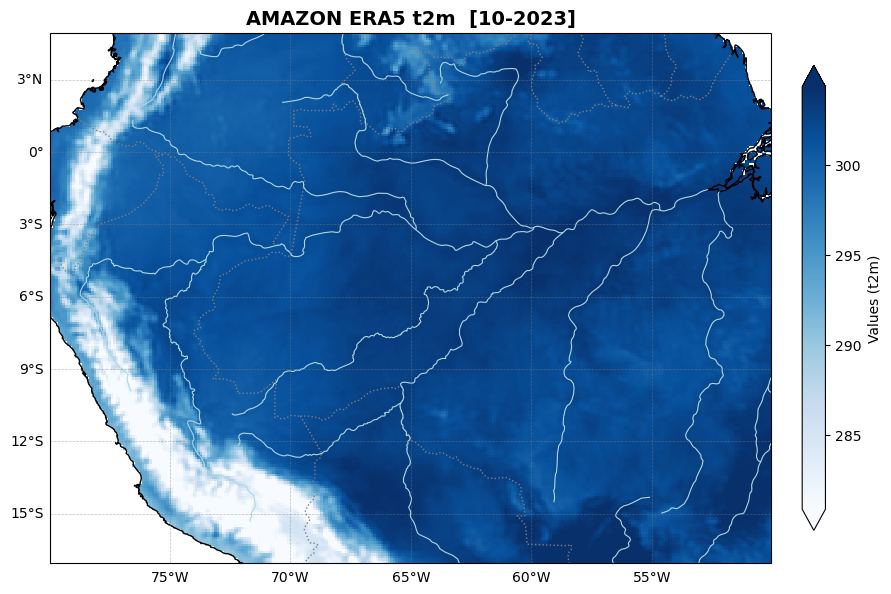

In [18]:
#Creating era5 input data for raster plots. These will work as predictors for the trained model.

feature_list = list(ds_era5_sliced.data_vars)
# Creating numeric list of ds_era5_merged features 
print("\n Available Features ")
for i, feature in enumerate(feature_list, 0):
    print(f" [{i}] {feature}")
print("\n Choose a number from the list above to create a raster plot for the corresponding feature.")
# User chooses a number according to list
try:
    era5_feature = int(input("Pick a number from the list: ")) 
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit() 

#Grab the string name from your list 
#era5_feature is integer
var_to_plot = feature_list[era5_feature]
print(var_to_plot)
# Users input name of basin for title
try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit()
# Users input date of map
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit() 
# Slice for input year & month
# Specific hour (23:00) required to avoid the midnight reset of features.
data_slice = ds_era5_sliced[var_to_plot].sel(valid_time=f'{map_year}-{map_month}-01 23:00', method='nearest')

# I only need month and year
time_str = data_slice.valid_time.dt.strftime("%m-%Y").item()
print(f"Preparing map for '{var_to_plot}' {time_str}")

# Dynamic .jpg title approach
output_jpg_era5 = f"../Maps/ERA5_{basin_name}_{var_to_plot}_{time_str}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_era5):
    output_jpg_era5 = f"../Maps/ERA5_{basin_name}_{var_to_plot}_{time_str}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_era5}")
    
# Fixing colour range
# Find the value that is smaller than 2% of the data
vmin = data_slice.quantile(0.02).item()
# Find the value that is smaller than 98% of the data
vmax = data_slice.quantile(0.98).item()

plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
plot = data_slice.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",     
    robust=True,
    vmin=vmin, vmax=vmax,    
    cbar_kwargs={     
        "orientation": "vertical",
        "fraction": 0.03,
        "pad": 0.04,
        "label": f"Values ({var_to_plot})"     
    }
)

ax.coastlines(resolution="10m", color="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')

ax.add_feature(cfeature.RIVERS, color='lightblue', linewidth=0.8)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title(f"{basin_name.upper()} ERA5 {var_to_plot.lower()}  [{time_str}]", fontsize=14, fontweight='bold')

# Remove default xarray labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.savefig(output_jpg_era5, dpi=300, bbox_inches="tight")
print(f" Raster plot saved as: {output_jpg_era5}")
print("Map")
plt.show()

# <font size="4"> Comparison: Actual and Predicted GRACE Maps </font>


Scanning directory: ../models/ 
 Available Models:
  [1] rf_4_new2.pkl
  [2] xgboost_4_new.pkl
  Selected: rf_4_new2.pkl
 Loading model...
Map saved to ../results/Comparison_GRACE_amazon_lwe_thickness_2022-05_1.jpg


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


 Map saved to: ../results/Comparison_GRACE_amazon_lwe_thickness_2022-05_1.jpg


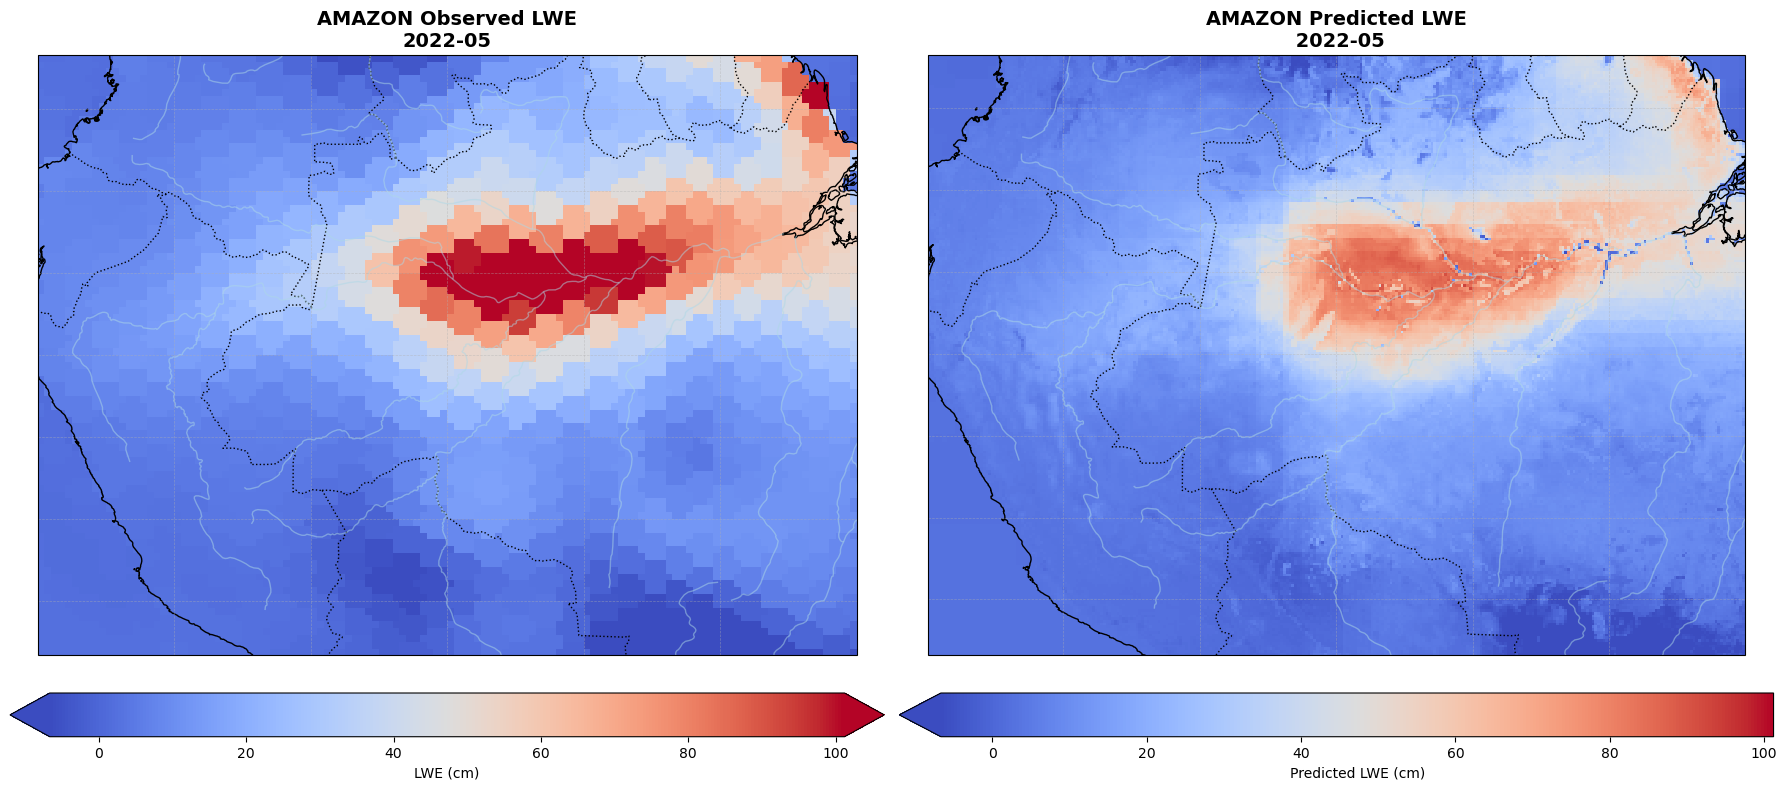

In [26]:
# Subplot raw_predict
models_dir = "../models/"
var_to_plot = "lwe_thickness"

# Select trained Model
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(Fore.RED + " Error: No .pkl files found in the models directory!")
        sys.exit()
# comment 
    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED +"  Invalid input. Please enter a number.")
        sys.exit()

except FileNotFoundError:
    print(Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

# input date
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

target_ym = f"{map_year}-{map_month:02d}"

# Dynamic .jpg title approach
output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{var_to_plot}_{target_ym}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_grace):
    output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{var_to_plot}_{target_ym}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_grace}")
    
# -------------------------
# GRACE raw data (mask by year/month)
# -------------------------
t_index = pd.DatetimeIndex(ds_grace_sliced.time.values)
mask = (t_index.year == map_year) & (t_index.month == map_month)

if not mask.any():
    print(Fore.RED + f" Error: Grace data not found for {target_ym}")
    sys.exit()

# If there are multiple timestamps in the same month, pick the first
idx = int(np.where(mask)[0][0])

data_actual = ds_grace_sliced[var_to_plot].isel(time=idx)
picked_ts = pd.Timestamp(data_actual.time.values)
time_str = picked_ts.strftime("%Y-%m")

# -------------------------
# ERA5 data after prediction
# -------------------------
input_data = era5_df[(era5_df["year"] == map_year) & (era5_df["month"] == map_month)].copy()

if input_data.empty:
    print(Fore.RED + f" Error: ERA5 data not found for {target_ym}.")
    sys.exit()
else:
    try:
        required_features = model.feature_names_in_
    except AttributeError:
        print("Using default features")
        required_features = features

    missing_feats = [c for c in required_features if c not in input_data.columns]
    if missing_feats:
        raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")

    X_pred = input_data[required_features]
    input_data["lwe_pred"] = model.predict(X_pred)

    ds_pred = input_data.groupby(["lat", "lon"])[["lwe_pred"]].mean().to_xarray()
    data_predicted = ds_pred["lwe_pred"]

# Plot
vmin = data_actual.quantile(0.02).item()
vmax = data_actual.quantile(0.98).item()

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Map 1
data_actual.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin=vmin, vmax=vmax
)
ax1.set_title(f"{basin_name.upper()} Observed LWE\n{time_str}", fontsize=14, fontweight="bold")
ax1.coastlines(resolution="10m")
ax1.add_feature(cfeature.BORDERS, linestyle=":")
ax1.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax1.gridlines(draw_labels=False, linewidth=0.5, linestyle="--", alpha=0.5)

# Map 2
data_predicted.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "Predicted LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin=vmin, vmax=vmax
)
ax2.set_title(f"{basin_name.upper()} Predicted LWE\n {time_str}", fontsize=14, fontweight="bold")
ax2.coastlines(resolution="10m")
ax2.add_feature(cfeature.BORDERS, linestyle=":")
ax2.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax2.gridlines(draw_labels=False, linewidth=0.5, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(output_jpg_grace, dpi=300, bbox_inches="tight")
print(f" Map saved to: {output_jpg_grace}")
plt.show()


Scanning directory: ../models/ 
 Available Models:
  [1] rf_4_new2.pkl
  [2] rf_amazon_5.pkl
  [3] xgboost_4_light.pkl
  [4] xgboost_4_new.pkl
  [5] xgboost_5_light.pkl
  [6] xgboost_5_parameters.pkl
  [7] xgboost_8_test.pkl
  Selected: xgboost_8_test.pkl
 Loading model...
Map saved to ../results/Comparison_GRACE_Amazon_2023-10_xgboost_8_test.pkl.jpg


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


 Map saved to: ../results/Comparison_GRACE_Amazon_2023-10_xgboost_8_test.pkl.jpg


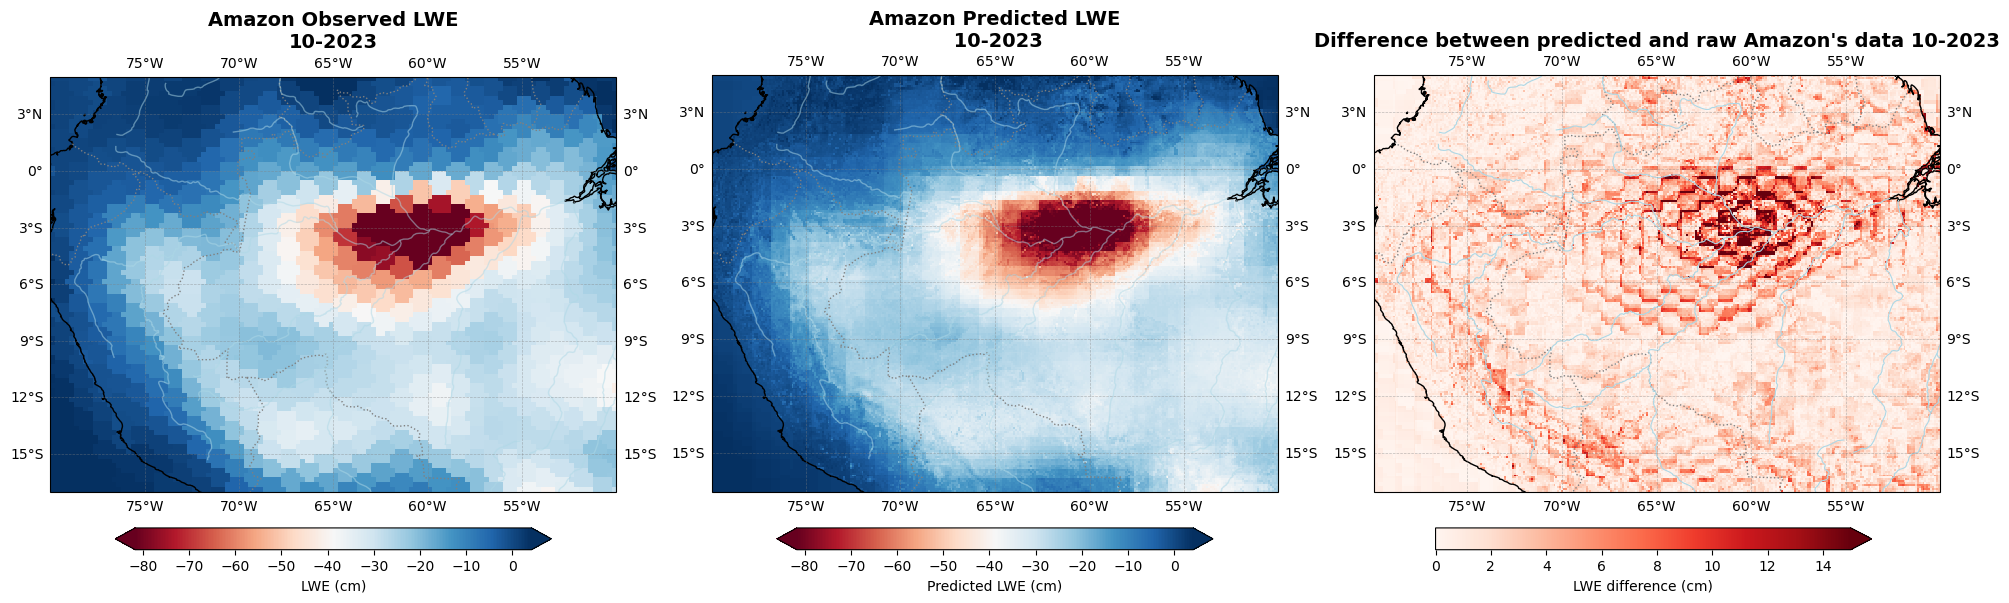

In [19]:
# Subplot raw_predict
models_dir = "../models/"
var_to_plot = "lwe_thickness"

# Select trained Model
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(Fore.RED + " Error: No .pkl files found in the models directory!")
        sys.exit()
# comment 
    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED +"  Invalid input. Please enter a number.")
        sys.exit()

except FileNotFoundError:
    print(Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

# input date
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

target_ym = f"{map_year}-{map_month:02d}"

# Dynamic .jpg title approach
output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{target_ym}_{selected_model_name}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_grace):
    output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{target_ym}_{selected_model_name}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_grace}")
    
# -------------------------
# GRACE raw data (mask by year/month)
# -------------------------
t_index = pd.DatetimeIndex(ds_grace_sliced.time.values)
mask = (t_index.year == map_year) & (t_index.month == map_month)

if not mask.any():
    print(Fore.RED + f" Error: Grace data not found for {target_ym}")
    sys.exit()

# If there are multiple timestamps in the same month, pick the first
idx = int(np.where(mask)[0][0])

data_actual = ds_grace_sliced[var_to_plot].isel(time=idx)
picked_ts = pd.Timestamp(data_actual.time.values)
time_str = picked_ts.strftime("%Y-%m")

# -------------------------
# ERA5 data after prediction
# -------------------------
input_ERA_data = era5_df[(era5_df["year"] == map_year) & (era5_df["month"] == map_month)].copy()

if input_ERA_data.empty:
    print(Fore.RED + f" Error: ERA5 data not found for {target_ym}.")
    sys.exit()
else:
    try:
        required_features = model.feature_names_in_
    except AttributeError:
        print("Using default features")
        required_features = features

    missing_feats = [c for c in required_features if c not in input_ERA_data.columns]
    if missing_feats:
        raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")

    X_pred = input_ERA_data[required_features]
    input_ERA_data["lwe_pred"] = model.predict(X_pred)

    ds_pred = input_ERA_data.groupby(["lat", "lon"])[["lwe_pred"]].mean().to_xarray()
    data_predicted = ds_pred["lwe_pred"]

# -------------------------
# lwe_difference
# -------------------------
input_diff_data = merged_4_diff[(merged_4_diff['year'] == map_year) & (merged_4_diff['month'] == map_month)]
if input_diff_data.empty:
    print(Fore.RED + f"No data found for {map_month}/{map_year}!")
    sys.exit()

ds_diff = input_diff_data.set_index(['lat', 'lon']).to_xarray()
data_slice_diff = ds_diff['lwe_difference']

# 4. Handle Time String Manually
# Since we lost the 'valid_time' column during earlier processing, we construct the string ourselves
time_str = f"{map_month:02d}-{map_year}" 

# Plot
vmin = data_actual.quantile(0.02).item()
vmax = data_actual.quantile(0.98).item()

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(20, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Map 1
data_actual.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    robust=True,
    cbar_kwargs={"label": "LWE (cm)", "orientation": "horizontal", "pad": 0.05, "fraction": 0.03},
    vmin=vmin, vmax=vmax
)
ax1.set_title(f"{basin_name} Observed LWE\n{time_str}", fontsize=14, fontweight="bold")
ax1.coastlines(resolution="10m")
ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax1.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax1.gridlines(draw_labels= True, linewidth=0.5, linestyle="--", alpha=0.5, color='gray')

# Map 2
data_predicted.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    robust=True,
    cbar_kwargs={"label": "Predicted LWE (cm)", "orientation": "horizontal", "pad": 0.05,"fraction": 0.03},
    vmin=vmin, vmax=vmax
)
ax2.set_title(f"{basin_name} Predicted LWE\n {time_str}", fontsize=14, fontweight="bold")
ax2.coastlines(resolution="10m")
ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax2.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax2.gridlines(draw_labels= True, linewidth=0.5, linestyle="--", alpha=0.5, color='gray')

# Map 3
# Note: data_slice is now an Xarray DataArray, so .plot works!
plot = data_slice_diff.plot.pcolormesh(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap="Reds",     
    robust=True,
    vmin=0 , vmax=15,    
    cbar_kwargs={"orientation": "horizontal", "fraction": 0.03,"pad": 0.05, "label": "LWE difference (cm)"}
    )

ax3.set_title(f"Difference between predicted and raw {basin_name}'s data {time_str}", fontsize=14, fontweight='bold')
ax3.coastlines(resolution="10m", color="black", linewidth=1)
ax3.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax3.add_feature(cfeature.RIVERS, color='lightblue', linewidth=0.8)
ax3.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(output_jpg_grace, dpi=300, bbox_inches="tight")
print(f" Map saved to: {output_jpg_grace}")
plt.show()